In [1]:
# Checking the images and labels
from google.colab import drive
drive.mount('/content/drive')
file_path='/content/drive/MyDrive/Colab Notebooks/Scraping'


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
# Reading all the images from the folders

import cv2
import os
import numpy as np
from tqdm import tqdm
from sklearn.utils import shuffle
import random
import matplotlib.pyplot as plt

image_data=[]
labels=[]
# Read the data inside the three folders

for label,item in tqdm(enumerate(os.listdir(file_path))):
  if item.find('.')<0:
    for images in os.listdir(file_path+'/'+item):
      # Reaad the images
      im=cv2.imread(file_path+'/'+item+'/'+images)
      # Convert the image into numpy array
      im=np.array(im)
      # Appending the image to the dataset
      image_data.append(im)
      # Creating the label for the image
      labels.append(label-2)

      # Save the numpy array with labels

# Shuffle the images and labels

image_data,labels=shuffle(image_data,labels)

5it [00:08,  1.63s/it]


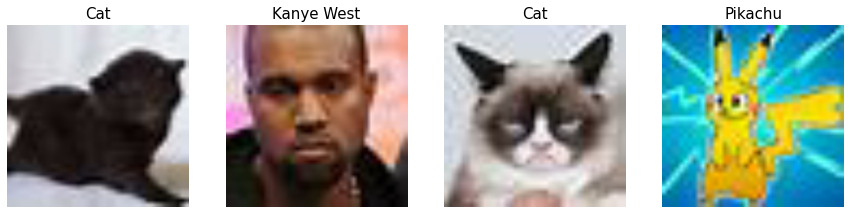

In [3]:
# Creating a dictionary for labels
dict={0:'Cat',1:'Pikachu',2:'Kanye West'}

# Testing if the images are labelled correctly
sampled_index=random.sample(list(np.arange(len(image_data))),4)

# Creating subplot for 4 images
plt.figure(figsize=(15,5))
for i in range(4):
  plt.subplot(1,4,i+1)
  plt.imshow(image_data[sampled_index[i]])
  plt.title(dict[labels[sampled_index[i]]],fontsize=15)
  plt.axis('off')

In [4]:
# Image Augmentations.
# In this case, we will be adding Horizontal Flip, rotate 45 anticlockwise, rotate 45 anticlockwise and increased brightness.

def augmentations(data):
  ''' The function will take a dataset, apply 4 transformations and share the data back'''

  flipped=[]
  clockw=[]
  anticlockw=[]
  bright=[]

  for image in tqdm(data):
    flipped.append(horizontal_flip(image))
    clockw.append(clockwise(image))
    anticlockw.append(anticlockwise(image))
    bright.append(brightness(image))

  return np.array(flipped),np.array(clockw),np.array(anticlockw),np.array(bright)


# Function for horizontal flip
def horizontal_flip(image):
  return cv2.flip(image,1)

# Function for 45 degree clockwise rotation
def clockwise(image):
  rot_matrix=cv2.getRotationMatrix2D((image.shape[0]/2,image.shape[1]/2),45,1)  # Midpoints, angle,scale
  im=cv2.warpAffine(image,rot_matrix,(image.shape[1],image.shape[0]))
  return im

# Function for 45 degree anticlockwise rotation
def anticlockwise(image):
  rot_matrix=cv2.getRotationMatrix2D((image.shape[0]/2,image.shape[1]/2),-45,1)  # Midpoints, angle,scale
  im=cv2.warpAffine(image,rot_matrix,(image.shape[1],image.shape[0]))
  return im

# Function for increasing brightness
def brightness(image):
  return cv2.addWeighted(image,0.8,image,0.9,0)

In [5]:
flipped,clock,anticlock,bright=augmentations(image_data)

100%|██████████| 1058/1058 [00:01<00:00, 577.42it/s]


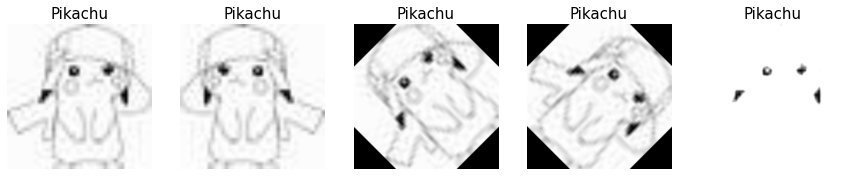

In [6]:
# checking the images
pos=random.sample(list(np.arange(len(image_data))),1)[0]
plot_data=[image_data[pos],flipped[pos],clock[pos],anticlock[pos],bright[pos]]

# Creating subplot for 4 images
plt.figure(figsize=(15,5))
for i in range(5):
  plt.subplot(1,5,i+1)
  plt.imshow(plot_data[i])
  plt.title(dict[labels[pos]],fontsize=15)
  plt.axis('off')

In [7]:
# Appending all the data
image_data=np.array(image_data)
labels=np.array(labels)
data=np.vstack((image_data,flipped,clock,anticlock,bright))
classes=np.hstack((labels,labels,labels,labels,labels))

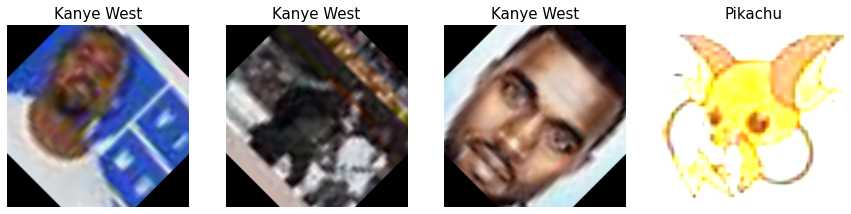

In [8]:
# Checking integrity of data
# Creating a dictionary for labels

# Testing if the images are labelled correctly
sampled_index=random.sample(list(np.arange(len(data))),4)

# Creating subplot for 4 images
plt.figure(figsize=(15,5))
for i in range(4):
  plt.subplot(1,4,i+1)
  plt.imshow(data[sampled_index[i]])
  plt.title(dict[classes[sampled_index[i]]],fontsize=15)
  plt.axis('off')

In [13]:
# # Creating embedding from VGG 15 for the images
# embedding=[]
# for image in tqdm(data):
#   embedding.append(model.predict(np.expand_dims(image,axis=0)))

embeding=np.load('/content/drive/MyDrive/Colab Notebooks/Scraping/embedding.npz')

100%|██████████| 5290/5290 [10:07<00:00,  8.70it/s]


In [15]:
# Saving the embedding for faser load
np.savez('/content/drive/MyDrive/Colab Notebooks/Scraping/embedding.npz',data=embedding)

In [12]:
# One Hot Encoding the classes
Y=np.zeros((len(classes),3))
for i,value in enumerate(classes):
  Y[i][value]=1


# Using transfer Learning from VGG 16 

In [9]:
# Loading the VGG NET model for transfer learning. 
from keras import Input
from keras.applications.vgg16 import VGG16
from keras.models import Model


new_input = Input(shape=(250, 250, 3)) 
base_model=VGG16(weights='/content/drive/MyDrive/Colab Notebooks/Scraping/vgg16_weights_tf_dim_ordering_tf_kernels_notop.h5',input_tensor=new_input,include_top=False, pooling='avg')

In [10]:
# Since images and ImageNet images are very similiar we are only more layers
model=Model(inputs=base_model.layers[0].input,outputs=base_model.get_layer('block5_pool').output)
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 250, 250, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 250, 250, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 250, 250, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 125, 125, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 125, 125, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 125, 125, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 62, 62, 128)       0     

In [19]:
# Creating a top layer

from keras.models import Sequential 
from keras.layers import Conv2D, MaxPooling2D,Dense,Flatten
top_layer=Sequential()
top_layer.add(Conv2D(512,(3,3),input_shape=(7,7,512),padding='same',activation='relu'))
top_layer.add(Conv2D(512,(3,3),padding='same',activation='relu'))
top_layer.add(MaxPooling2D((2,2)))


top_layer.add(Flatten())
top_layer.add(Dense(256,activation='relu'))
top_layer.add(Dense(64,activation='relu'))
top_layer.add(Dense(8,activation='relu'))
top_layer.add(Dense(3,activation='softmax'))

# top_layer.compile(optimizer='adam',loss='binary_crossentropy',metrics=['accuracy'])

In [20]:
# from tensorflow import keras
# optimizer = keras.optimizers.Adam(lr=0.01)
top_layer.compile(optimizer='Adam',loss='binary_crossentropy',metrics=['accuracy'])
embedding=np.squeeze(np.array(embedding))
top_layer.fit(embedding,np.array(Y),epochs=20)

Epoch 1/20
166/166 [==============================] - 5s 23ms/step - loss: 0.6973 - accuracy: 0.5051
Epoch 2/20
166/166 [==============================] - 4s 22ms/step - loss: 0.4407 - accuracy: 0.5261
Epoch 3/20
166/166 [==============================] - 4s 22ms/step - loss: 0.3603 - accuracy: 0.6454
Epoch 4/20
166/166 [==============================] - 4s 22ms/step - loss: 0.1924 - accuracy: 0.9652
Epoch 5/20
166/166 [==============================] - 4s 22ms/step - loss: 0.0814 - accuracy: 0.9616
Epoch 6/20
166/166 [==============================] - 4s 23ms/step - loss: 0.0176 - accuracy: 0.9940
Epoch 7/20
166/166 [==============================] - 4s 24ms/step - loss: 0.0066 - accuracy: 0.9977
Epoch 8/20
166/166 [==============================] - 4s 22ms/step - loss: 0.0085 - accuracy: 0.9960
Epoch 9/20
166/166 [==============================] - 4s 22ms/step - loss: 0.0021 - accuracy: 0.9987
Epoch 10/20
166/166 [==============================] - 4s 22ms/step - loss: 0.0012 - accura

In [28]:
# Saving the models
model.save('/content/drive/MyDrive/Colab Notebooks/Scraping/vgg_layer.h5')
top_layer.save('/content/drive/MyDrive/Colab Notebooks/Scraping/top_layer.h5')